In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
deaths_time_series = pd.read_csv("time_series_covid19_deaths_US.csv")
confirmed_cases_time_series = pd.read_csv("time_series_covid19_confirmed_US.csv")
abridged_counties = pd.read_csv("abridged_couties.csv")
states_recent = pd.read_csv("4.18states.csv")

# EDA: Exploratory Data Analysis

## Looking at the Data Sets and processing them
Our main goal here are
- To see if we can identify any trends 
- Find any interesting features that we can use to create a model
- Process the features to give a nice featureized matrix


In [3]:
print(states_recent.columns)
"""
We can see that we have the incident rate which tells us the number of people infected out of 100,000.
We can also see the testing rate and the Mortality Rate.
Lets see if we can look at the mortality rate in each state

"""
mortiliaty_rate_per_state = states_recent.loc[states_recent["Country_Region"]=="US"][["Mortality_Rate","Province_State"]].groupby("Province_State").sum()

#Comment out the line below to see the mortality rate in each state.
# print(mortiliaty_rate_per_state) 

"""
We can see that this rate is different for each state. The Virus's mortality rate should attack uniformly 
in place where the population is large and the measures are the same. 
Perhaps the diffrence in these measures of containment and the healthcould give us a reasonable idea 
as to how it might change in different settings.

"""


Index(['Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_',
       'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS', 'Incident_Rate',
       'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'UID', 'ISO3',
       'Testing_Rate', 'Hospitalization_Rate'],
      dtype='object')


"\nWe can see that this rate is different for each state. The Virus's mortality rate should attack uniformly \nin place where the population is large and the measures are the same. \nPerhaps the diffrence in these measures of containment and the healthcould give us a reasonable idea \nas to how it might change in different settings.\n\n"

In [4]:
"""

Now that we think we might be able to predict the mortality rate, 
we need a way to featureise what determines the number of deaths per state. 
For this, we aare going to look at the abridged counties dataset and see what columns can provide some information
as to what we can use.

"""

abridged_counties.columns

"""

From this, the following colums seem most interesting:
PopulationEstimate2018, 
PopulationDensityperSqMile2010,
MedianAge2010,
TotalM.D.'s,TotNon-FedandFed2017, 
#Hospitals, 
#ICU_beds. 

"""
intersting_features = ["State", "CountyName", # these two columns help sort the abridged_counties dataset
                       "PopulationEstimate2018", 
                       "PopulationDensityperSqMile2010",
                       "MedianAge2010",
                       "TotalM.D.'s,TotNon-FedandFed2017",
                       "#Hospitals", 
                       "#ICU_beds"]

"""Now to get the new dataset"""
new_params = abridged_counties[intersting_features].groupby(by="State").sum()
new_params = new_params.rename({"District Of Columbia":"District of Columbia"})

#remove the comment from the next line to see what the new dataframe looks like
# new_params

In [5]:
"""
We now want to model the death toll of each state. 
The goal is to make a feature that can tell us about 
the change in mortality rate as the disease progresses

"""

#uncomment the line below to see the columns
# print(deaths_time_series.columns)

"""
we can see that there are some columns that do are not needed. 
We are going to drop them.

"""

#this line below should remove the unneeded columns
ded = deaths_time_series.groupby(by="Province_State").sum().drop(columns = ["UID",
                                                                            "code3", 
                                                                            "FIPS", 
                                                                            "Lat",
                                                                            "Long_",
                                                                            "Population"])

"""
We now want to look at the states of the US. 
We will also exclude Alaska and Hawaii as they are not present in the abridged counties dataset
and might causes NAN values later.
We are also going to remove the terriorites of the US and the ships in the water 
as we do not have complete information on them.
"""

ded = ded.drop(labels = ["Diamond Princess",
                         "Virgin Islands", 
                         "American Samoa", 
                         "Grand Princess",
                         "Guam", 
                         "Puerto Rico",
                         "Northern Mariana Islands",
                         "Alaska", 
                         "Hawaii"])

#as the date's are going to be hard to understand, we are going to reset them as days since first reports
ded.columns = np.arange(88)

#uncomment the below line to see how the dataset looks
# ded

# Measuring the different expnential growths in different states

We currently have a time series of the data and we need a single number that tells us how the death rate will be. For this, we are first going to fit a function to the distributions per state and then go from there. 
We can see that as the distribution is an exponential growth, we should fit an exponential curve to the deaths. This curve should represent the number of cumulative deaths. The gradient of this should give us an idea as to the number of new deaths one can expect in a day.

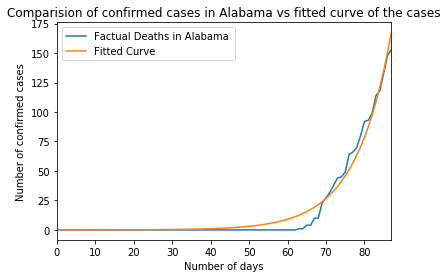

In [6]:
import math
from scipy.optimize import curve_fit

"""
First, we are going to define an exponential function to fit to this distribution
"""
def exp_function (x,a,b):
    return a*b**x

"""
Looking at the plot below, we can see that the numbe of deaths
is indeed an exponential increase.
"""

alabama = ded.iloc[0]

alabama.plot(label = "Factual Deaths in Alabama ")
plt.xlabel("Number of days")
plt.ylabel("Number of confirmed cases")
plt.title("Comparision of confirmed cases in Alabama vs fitted curve of the cases")

"""
Using our defined function, we are going to model it 
and then from the parameters, plot the function and compare them. 

"""

x_plt = np.arange(88)
alabama_exp = curve_fit(f = exp_function,
                        xdata = x_plt, 
                        ydata = alabama)

plt.plot(x_plt,
         exp_function(x_plt, 
                             alabama_exp[0][0], 
                             alabama_exp[0][1]),
         label = "Fitted Curve")

plt.legend()


In [7]:
"""
The above fit is accurate. So we are now going to model that for each state
For each state, there is an Inital Value and the Change factor.
Inital Value : The inital death rate for day 0
Change factor : The exponential increase of the death per day

"""

number_of_us_states = 49
curve_fitted_parameters = {}
curve_exp_a = []
curve_exp_b = []
statessss = []

for i in range(number_of_us_states):
    
    state_fig = ded.iloc[i]
    state_name = ded.index[i]
    days = np.arange(88)
    
    fitted_curve = curve_fit(f = exp_function, xdata= days, ydata= state_fig)
    curve_a = fitted_curve[0][0]
    curve_b = fitted_curve[0][1]
    
    statessss.append(state_name)
    curve_exp_a.append(curve_a)
    curve_exp_b.append(curve_b)
    

curve_fitted_parameters = {"State" : statessss, "Inital Value" : curve_exp_a, "Change Factor" : curve_exp_b}
exp_pred = pd.DataFrame(curve_fitted_parameters).set_index("State")
#just so see, we're going to to look at which state as the highest change factor. 
# exp_pred.sort_values(by = "Change Factor", ascending = False)

In [8]:
"""
This will compute the gradient and show us the predicted mortality rate per day

"""
def derrivative(x,a,b):
    return a*(b**x)*(np.log(b))

#following is a sample for the death rate on day 4
# print(derrivative(4, exp_pred["Inital Value"], exp_pred["Change Factor"]))

## Quantizating the Lockdown Parameters
For each state, we need to look at how the lockdown also comes into play. So for that, we need to consult the news. We used two articles : 

- Walls Street Journal  https://www.wsj.com/articles/a-state-by-state-guide-to-coronavirus-lockdowns-11584749351
- Walls Street Journal https://www.wsj.com/articles/a-state-by-state-guide-to-coronavirus-lockdowns-11584749351

We then quantized each lockdown and gave them a score of 0-5 where 0 represents no lockdown and 5 represents a maximum stay at home

In [9]:

exp_pred["Lockdown Restrictions"] = np.zeros(49)

"""These states have 0 or the least lockdown restrictions"""
zeros = ["Utah", "Wyoming", "North Dakota", "South Dakota", 
         "Nebraska", "Iowa", "Oklahoma","Arkansas"]

"""These states have 1, i.e some sort of a lockdown but for a short period of timestart lockdown on april 1st,
are now reopening"""
ones = ["Texas", "Oklahoma", "Kansas", 
        "Missouri", "Florida", "Alabama", "Mississippi", 
        "Georgia", "Tennessee", "South Carolina", 
        "Pennsylvania", "Maine"]

"""These states have a score of 2, i.e they went into lockdown but are now opening, march 27 lockdown, reopening"""
twos = ["Idaho", "Montana", "Colorado",
        "Indiana", "West Virginia", "Rhode Island", "North Carolina",
        "New Hampshire", "Nevada", "Arizona"]

"""These states have a score of 3, i.e a might not open right not, march 27 lockdown, not reopening soon"""
threes = ["New Mexico", "Ohio", "Vermont"]

"""These states have a score of 4, i.e strong lockdowns but not hotspots, march 27, not opening"""
fours = ["Minnesota", "Wisconsin", "Michigan", "Kentucky", "Virginia",
          "Maryland", "Delaware", "Massachusetts", "District of Columbia"]

"""These states have a score of 5, i.e they have strong lickdowns and are hubs, march 21 not opening"""
fives = ["New York", "Washington", "California", "Oregon", 
         "Louisiana","Connecticut", "Illinois", "New Jersey" ]


for i in zeros:
    exp_pred.at[i, "Lockdown Restrictions"] = 0
for i in ones:
    exp_pred.at[i, "Lockdown Restrictions"] = 1
for i in twos:
    exp_pred.at[i, "Lockdown Restrictions"] = 2
for i in threes:
    exp_pred.at[i, "Lockdown Restrictions"] = 3
for i in fours:
    exp_pred.at[i, "Lockdown Restrictions"] = 4
for i in fives:
    exp_pred.at[i, "Lockdown Restrictions"] = 5

exp_pred.sort_index()
exp_pred

,Inital Value,Change Factor,Lockdown Restrictions
State,,,
Alabama,0.013743,1.114215,1.0
Arizona,0.025388,1.108259,2.0
Arkansas,0.012666,1.098110,0.0
California,0.161973,1.107643,5.0
Colorado,0.077816,1.104527,2.0
Connecticut,0.008070,1.146633,5.0
Delaware,0.001898,1.128369,4.0
District of Columbia,0.001973,1.132534,4.0
Florida,0.066531,1.114452,1.0


# Trends in our data

Now, we are going to look and see the relation of features of the states with their respective mortality rate

Text(0.5, 1.0, 'Relation of mortality rate with population Density')

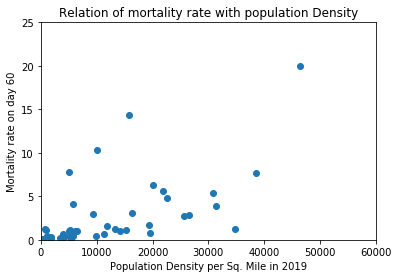

In [10]:
"""Comparing the mortality rate with the population Density"""

plt.scatter(new_params["PopulationDensityperSqMile2010"], derrivative(60, exp_pred["Inital Value"], exp_pred["Change Factor"]))
plt.xlim(0,60000)
plt.ylim(0,25)
plt.xlabel("Population Density per Sq. Mile in 2019")
plt.ylabel("Mortality rate on day 60")
plt.title("Relation of mortality rate with population Density")


Text(0.5, 1.0, 'Relation of mortality rate with population ')

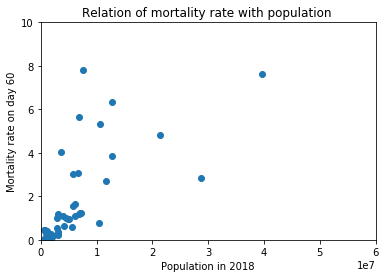

In [11]:
"""Comparing the mortality rate with the population """

plt.scatter(new_params["PopulationEstimate2018"], derrivative(60, exp_pred["Inital Value"], exp_pred["Change Factor"]))
plt.xlim(0,60000000)
plt.ylim(0,10)
plt.xlabel("Population in 2018")
plt.ylabel("Mortality rate on day 60")
plt.title("Relation of mortality rate with population ")



Text(0.5, 1.0, 'Relation of mortality rate with number of hospitals')

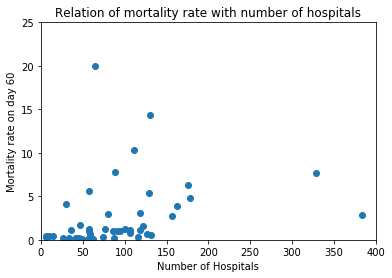

In [12]:
"""Comparing the mortality rate with the number of Hospitals"""

plt.scatter(new_params["#Hospitals"], derrivative(60, exp_pred["Inital Value"], exp_pred["Change Factor"]))
plt.xlim(0,400)
plt.ylim(0,25)
plt.xlabel("Number of Hospitals")
plt.ylabel("Mortality rate on day 60")
plt.title("Relation of mortality rate with number of hospitals")



# Making a model

We plan to use an SIR model which tells us about how a given population with the qunataites above should react to exposure to a pandemic:

- number of people being infected
- total uneffected population
- number of people who have recovered
- number of people who have died

## Using Linear Regression to predict the death rate in any given population

We are going to create a model that takes in the following parameters and tell us what the death rate could be on a given day T

- Population
- Population Density
- Number of Hospitals
- Number of ICU Beds
- Number of Medical Doctors
- Median Age


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import sklearn
from sklearn.model_selection import cross_val_score



def predicting_epademic_kill_rate(day, model_config, state_features, kill_rate_predictor):
    
  
    '''
    generates kill rate on T + given day using linear regression model
    
    input: required day model config, target day
    output: kill rate
    '''
    
    new_val = {"#Hospitals"                      : model_config['number_of_hospitals'],
               "PopulationEstimate2018"          : model_config['population'],
               "#ICU_beds"                       : model_config['number_of_ICU_beds'],
               "TotalM.D.'s,TotNon-FedandFed2017": model_config['number_of_MDs'],
               "PopulationDensityperSqMile2010"  : model_config["population density"],
               "MedianAge2010"                   : model_config["median age"]
              }
    
    new_entry = pd.DataFrame(new_val)

    x = state_features.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    

    df["lockdown"] = kill_rate_predictor.reset_index()["Lockdown Restrictions"]
    y = derrivative(day, exp_pred["Inital Value"], exp_pred["Change Factor"])
    
    x_train, x_test = df[:-5], df[-5:]
    y_train, y_test = y[:-5], y[-5:]
    my_model = LinearRegression()
    some_error = cross_val_score(my_model, df, y, cv = 5, scoring = "neg_mean_squared_error")

    my_model.fit(x_train, y_train)
    y_hat_test = my_model.predict(x_test)
    


    error = sklearn.metrics.mean_squared_error(y_hat_test, y_test)
    
    state_features = state_features.append(new_entry, sort = False)
    new_x = state_features.reset_index().drop(columns = ['index']).values #returns a numpy array

    new_x_scaled = min_max_scaler.fit_transform(new_x)
    new_df = pd.DataFrame(new_x_scaled)
    new_df["lockdown"] = kill_rate_predictor.reset_index()["Lockdown Restrictions"]
    
    test = df.loc[[df.shape[0]-1]]
    test["lockdown"] = model_config['lockdown_rating'][0]
    predicted_rate = my_model.predict(test)
    
    return predicted_rate[0], error, abs(some_error.mean())

Now, input your current state/areas parameters in the cell that you intend to calculate

In [66]:
model_config = {
    'number_of_hospitals': [60], 
    'population'         : [10000],
    'number_of_ICU_beds' : [600],
    'number_of_MDs'      : [600],
    'lockdown_rating'    : [3.0],
    "population density" : [100], # in sq.mile 
    "median age"         : [45],                            }

target_day = 50 #predicting after 2 months of infection spread

prediction  = predicting_epademic_kill_rate(day=target_day, 
                                            model_config=model_config, 
                                            state_features=new_params,
                                            kill_rate_predictor=exp_pred)

print ('Predicted kill rate of people infected: ', prediction[0])
print("Cross Validation error: ", prediction[1])

Predicted kill rate of people infected:  0.24506822092591235
Cross Validation error:  4.9228591791381255


# The SIR model

In [67]:
population_params = {"population"       : 10000, 
                     "inital infected"  : 10, 
                     "inital recovered" : 2
                    }
my_infection_params = {"infection weight" : 1.1, # number of people 1 person an infect in a day
                       "infection period" : 14    # number of days person is ill and can infect others
                      }

In [68]:
def better_trial(day, pop_params, infection_params ):
    
    initial_pop = pop_params["population"]
    initial_infected = pop_params["inital infected"]
    initial_recovered  = pop_params["inital recovered"]    
    
    
    infection_weight = infection_params["infection weight"]
    infection_period = infection_params["infection period"]
    number_of_people_infected_by_one_person = infection_weight * infection_period

    recovery_rate_per_day = 1 / infection_period
    current_carriers = initial_infected
    initial_susceptible = initial_pop - initial_infected - initial_recovered
    
    if day < 0:
        
        return "Error: Day cannot be less than zero."
    
    elif day == 0: # inital day of infection/calibration
        
        return (initial_infected, initial_recovered, initial_susceptible)
        
    else:
        
        day_recovered = (current_carriers * recovery_rate_per_day)
        day_infected = (initial_infected * infection_weight *(initial_susceptible/initial_pop))
        
        new_initial_infected = initial_infected +  day_infected - day_recovered 
        new_initial_recovered = initial_recovered + day_recovered
        new_initial_susceptible = initial_susceptible - day_infected
        
        if new_initial_susceptible < 0:
            new_initial_susceptible = 0
            
        if new_initial_infected > (initial_pop):
            new_initial_infected = initial_infected - day_recovered
            
        if new_initial_infected <= 0:
            new_initial_infected = initial_infected
        return (int(new_initial_infected), int(new_initial_recovered), int(new_initial_susceptible))

    
def get_that_day(my_day, population_params):
    
    temp_pop_params = population_params
    
    
    my_day_data = better_trial(0, pop_params= temp_pop_params, infection_params = my_infection_params )

    infected_data = [my_day_data[0]]
    recovered_data = [my_day_data[1]]
    suseptable_data = [my_day_data[2]]
    
    death_data = [0]
    error_data = []
    
    for i in range(my_day):
        
            kill_rate, _, error = predicting_epademic_kill_rate(i, model_config, new_params, exp_pred)

            deaths = int(kill_rate*(infected_data[i]))
            temp_pop_params["population"] -= deaths
            
            temp_pop_params["inital infected"] = my_day_data[0] - deaths
            temp_pop_params["inital recovered"] = my_day_data[1]
            
            my_day_data = better_trial(i, temp_pop_params, my_infection_params)
            
            infected_data.append(my_day_data[0])
            recovered_data.append(my_day_data[1])
            suseptable_data.append(my_day_data[2])
            
            death_data.append(death_data[i]+deaths)
            error_data.append(error)
            
    overall_dist = {"Infected people" : infected_data,
                    "At risk people" : suseptable_data, 
                    "Recovered people" : recovered_data, 
                    "Deaths" : death_data      
                   }
    overall_df = pd.DataFrame(overall_dist)
    print("Mean Squared Error:", np.mean(error_data))
    return overall_df 
    
    
    


Mean Squared Error: 1.9251967412391446


,Infected people,At risk people,Recovered people,Deaths
0,10,9988,2,0
1,10,9988,2,0
2,20,9977,2,0
3,40,9956,3,0
4,80,9913,5,0
5,161,9827,10,0
6,323,9654,21,0
7,641,9313,44,1
8,1246,8660,89,4
9,2332,7479,177,11


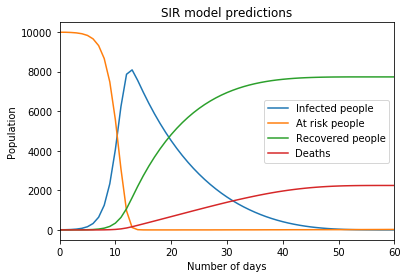

In [69]:
#note, ignore the warnings
my_day = get_that_day(60, population_params)

my_day.plot()

plt.xlabel("Number of days")
plt.ylabel("Population")
plt.title("SIR model predictions")



my_day
